In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
df

,Hour,Lane 1 Flow (Veh/Hour),Lane 1 Delay(60) (Veh-Hours),Lane 2 Flow (Veh/Hour),Lane 2 Delay(60) (Veh-Hours),Lane 3 Flow (Veh/Hour),Lane 3 Delay(60) (Veh-Hours),Flow (Veh/Hour),Delay (V_t=60) (Veh-Hours),# Lane Points,% Observed,Timestamp,Year,Month,Day,HourOfDay
0,2022-01-01 00:00:00,82,0.0,234,0.0,132,0.0,448,0.0,36,0.0,2022-01-01 00:00:00,2022,1,1,0
1,2022-01-01 01:00:00,39,0.0,158,0.0,90,0.0,287,0.0,36,0.0,2022-01-01 01:00:00,2022,1,1,1
2,2022-01-01 02:00:00,30,0.0,123,0.0,54,0.0,207,0.0,36,0.0,2022-01-01 02:00:00,2022,1,1,2
3,2022-01-01 03:00:00,13,0.0,84,0.0,43,0.0,140,0.0,36,0.0,2022-01-01 03:00:00,2022,1,1,3
4,2022-01-01 04:00:00,12,0.0,88,0.0,43,0.0,143,0.0,36,0.0,2022-01-01 04:00:00,2022,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29387,2025-05-09 15:00:00,652,0.0,821,0.1,731,0.5,2204,0.6,36,0.0,2025-05-09 15:00:00,2025,5,9,15
29388,2025-05-09 16:00:00,875,0.3,1012,1.0,895,1.5,2782,2.8,36,0.0,2025-05-09 16:00:00,2025,5,9,16
29389,2025-05-09 17:00:00,741,0.0,899,0.6,795,1.0,2435,1.8,36,0.0,2025-05-09 17:00:00,2025,5,9,17
29390,2025-05-09 18:00:00,548,0.0,718,0.0,645,0.2,1911,0.2,36,0.0,2025-05-09 18:00:00,2025,5,9,18


In [ ]:
df = pd.read_excel("TollPlaza.xlsx")
df = df.sort_values('Hour').set_index('Hour')

# 2) Create lag features for total flow (you can do the same for delays if desired)
for lag in (1,2,3):
    df[f'Flow_lag{lag}'] = df['Flow (Veh/Hour)'].shift(lag)

# drop rows with NaNs caused by shifting
df = df.dropna(subset=[f'Flow_lag{l}' for l in (1,2,3)])

# 3) Define features & target
features = ['Flow_lag1','Flow_lag2','Flow_lag3']
target   = 'Flow (Veh/Hour)'

# split in time: train up to today, test on the most recent 20%
split_point = int(len(df)*0.8)
train_df = df.iloc[:split_point]
test_df  = df.iloc[split_point:]

X_train = train_df[features].values
y_train = train_df[target].values
X_test  = test_df[features].values
y_test  = test_df[target].values

# 4) scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) build & fit
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(1),
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_scaled, y_train,
          epochs=50, batch_size=16,
          validation_split=0.2, verbose=1)

# 6) iterative forecasting to 2025-12-31 23:00
last_obs = df[features].iloc[-1:].copy()  # shape (1,3)
future_idx = pd.date_range(
    start = df.index[-1] + pd.Timedelta(hours=1),
    end   = '2025-12-31 23:00:00',
    freq  = 'H'
)

preds = []
for _ in future_idx:
    Xp = scaler.transform(last_obs)
    yhat = float(model.predict(Xp))
    preds.append(yhat)
    # roll the lags forward
    new_row = {
        'Flow_lag1': yhat,
        'Flow_lag2': last_obs['Flow_lag1'].values[0],
        'Flow_lag3': last_obs['Flow_lag2'].values[0],
    }
    last_obs = pd.DataFrame(new_row, index=[0])

forecast = pd.Series(preds, index=future_idx, name='Forecasted Flow')
print(forecast.tail())

Epoch 1/50
1176/1176 [==============================] - 3s 2ms/step - loss: 904719.9375 - mae: 646.8219 - val_loss: 102104.3828 - val_mae: 201.6030
Epoch 2/50
1176/1176 [==============================] - 2s 2ms/step - loss: 99345.7188 - mae: 215.3174 - val_loss: 73944.7344 - val_mae: 178.0573
Epoch 3/50
1176/1176 [==============================] - 2s 1ms/step - loss: 81042.8516 - mae: 191.6556 - val_loss: 65600.7891 - val_mae: 168.0120
Epoch 4/50
1176/1176 [==============================] - 2s 1ms/step - loss: 72742.9141 - mae: 179.3382 - val_loss: 59056.9844 - val_mae: 160.7673
Epoch 5/50
1176/1176 [==============================] - 2s 2ms/step - loss: 67131.3359 - mae: 170.4711 - val_loss: 54787.6562 - val_mae: 151.4234
Epoch 6/50
1176/1176 [==============================] - 2s 1ms/step - loss: 62943.2773 - mae: 162.3669 - val_loss: 50086.7930 - val_mae: 144.4919
Epoch 7/50
1176/1176 [==============================] - 2s 1ms/step - loss: 59941.0820 - mae: 155.4707 - val_loss: 48346.1

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 39ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 33ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 32ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 4ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 31ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 31ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 32ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 37ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 7ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 8ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 40ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 52ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 40ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 34ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 34ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 35ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 45ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 31ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 31ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 8ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 8ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 30ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 8ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 6ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 9ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 30ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 31ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 41ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 6ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 50ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 18ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 11ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 7ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 40ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 39ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 42ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 36ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 36ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 34ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 49ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 22ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 13ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 32ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 10ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 12ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 9ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 25ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 5ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 32ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 36ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 21ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 29ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 30ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 17ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 19ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 15ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 23ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 16ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 14ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 32ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - ETA: 0s

C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 26ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 28ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 20ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 24ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 32ms/step


C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Temp\ipykernel_7380\600240613.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(model.predict(Xp))
c:\Users\joelt\GSR\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn

1/1 [==============================] - 0s 27ms/step


184/184 [==============================] - 1s 2ms/step


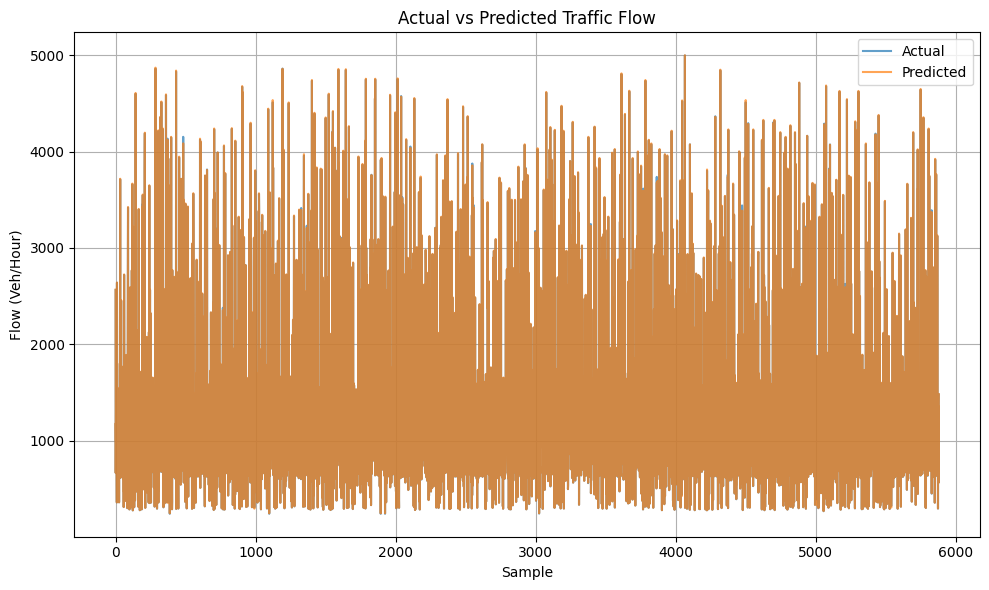

In [3]:
y_pred = model.predict(X_test_scaled).flatten()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Traffic Flow')
plt.xlabel('Sample')
plt.ylabel('Flow (Veh/Hour)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

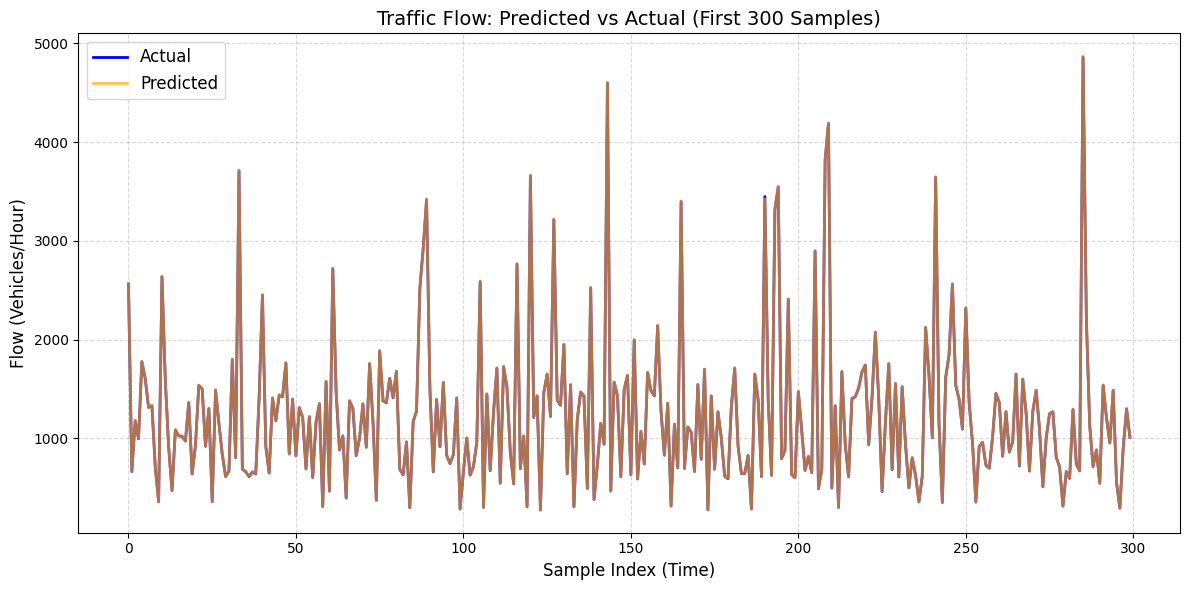

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Only show a sample for better readability
sample_range = 300  # Adjust this to zoom in more or less
y_test_sample = y_test.values[:sample_range]
y_pred_sample = y_pred[:sample_range]

plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_sample, label='Predicted', color='orange', linewidth=2, alpha=0.7)
plt.title('Traffic Flow: Predicted vs Actual (First {} Samples)'.format(sample_range), fontsize=14)
plt.xlabel('Sample Index (Time)', fontsize=12)
plt.ylabel('Flow (Vehicles/Hour)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.read_excel("oppo_TollPlaza.xlsx")
df = df.sort_values('Hour').set_index('Hour')

# 2) Create lag features for total flow (you can do the same for delays if desired)
for lag in (1,2,3):
    df[f'Flow_lag{lag}'] = df['Flow (Veh/Hour)'].shift(lag)

# drop rows with NaNs caused by shifting
df = df.dropna(subset=[f'Flow_lag{l}' for l in (1,2,3)])

# 3) Define features & target
features = ['Flow_lag1','Flow_lag2','Flow_lag3']
target   = 'Flow (Veh/Hour)'

# split in time: train up to today, test on the most recent 20%
split_point = int(len(df)*0.8)
train_df = df.iloc[:split_point]
test_df  = df.iloc[split_point:]

X_train = train_df[features].values
y_train = train_df[target].values
X_test  = test_df[features].values
y_test  = test_df[target].values

# 4) scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) build & fit
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(1),
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_scaled, y_train,
          epochs=50, batch_size=16,
          validation_split=0.2, verbose=1)

# 6) iterative forecasting to 2025-12-31 23:00
last_obs = df[features].iloc[-1:].copy()  # shape (1,3)
future_idx = pd.date_range(
    start = df.index[-1] + pd.Timedelta(hours=1),
    end   = '2025-12-31 23:00:00',
    freq  = 'H'
)

preds = []
for _ in future_idx:
    Xp = scaler.transform(last_obs)
    yhat = float(model.predict(Xp))
    preds.append(yhat)
    # roll the lags forward
    new_row = {
        'Flow_lag1': yhat,
        'Flow_lag2': last_obs['Flow_lag1'].values[0],
        'Flow_lag3': last_obs['Flow_lag2'].values[0],
    }
    last_obs = pd.DataFrame(new_row, index=[0])

forecast = pd.Series(preds, index=future_idx, name='Forecasted Flow')
print(forecast.tail())

Epoch 1/50
1176/1176 [==============================] - 5s 4ms/step - loss: 10.1009 - mae: 0.8440 - val_loss: 11.3933 - val_mae: 0.9455
Epoch 2/50
1176/1176 [==============================] - 4s 3ms/step - loss: 9.6094 - mae: 0.7806 - val_loss: 11.1497 - val_mae: 0.9263
Epoch 3/50
1176/1176 [==============================] - 4s 4ms/step - loss: 9.3152 - mae: 0.7728 - val_loss: 10.7519 - val_mae: 0.8282
Epoch 4/50
1176/1176 [==============================] - 4s 3ms/step - loss: 9.1122 - mae: 0.7363 - val_loss: 10.5503 - val_mae: 0.7501
Epoch 5/50
1176/1176 [==============================] - 3s 3ms/step - loss: 8.8906 - mae: 0.7251 - val_loss: 10.4559 - val_mae: 0.7869
Epoch 6/50
1176/1176 [==============================] - 3s 3ms/step - loss: 8.7348 - mae: 0.7032 - val_loss: 9.9919 - val_mae: 0.7976
Epoch 7/50
1176/1176 [==============================] - 3s 3ms/step - loss: 8.5802 - mae: 0.6967 - val_loss: 9.8070 - val_mae: 0.7542
Epoch 8/50
1176/1176 [==============================] - 

184/184 [==============================] - 1s 3ms/step


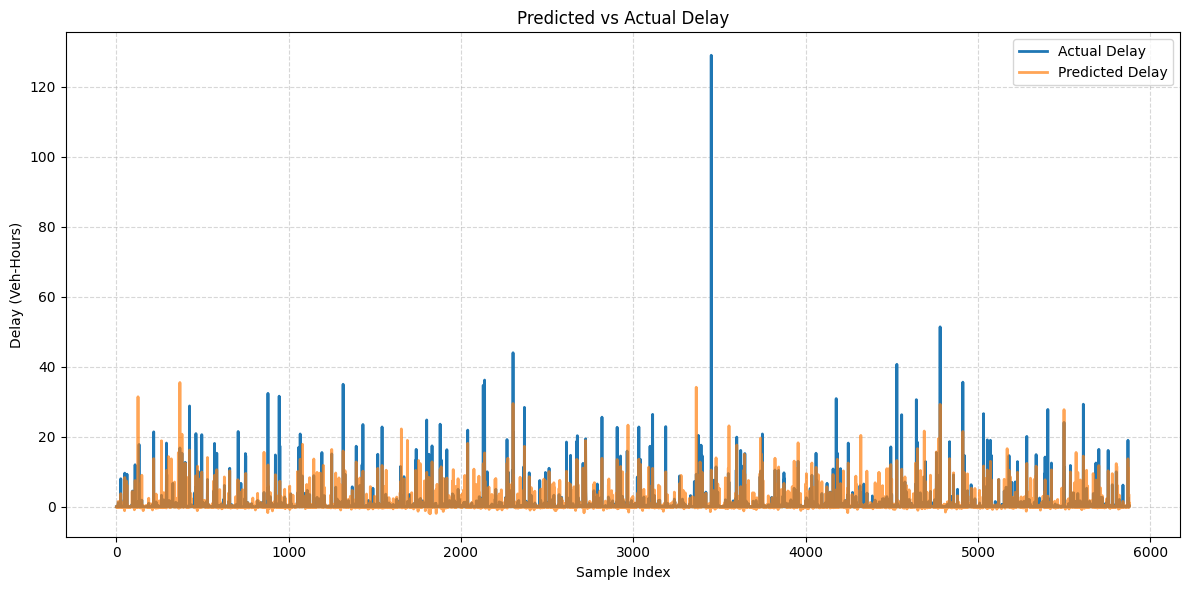

In [6]:
# Predict
y_pred = model.predict(X_test_scaled).flatten()

# Plot predicted vs actual delay
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Delay', linewidth=2)
plt.plot(y_pred, label='Predicted Delay', linewidth=2, alpha=0.7)
plt.title('Predicted vs Actual Delay')
plt.xlabel('Sample Index')
plt.ylabel('Delay (Veh-Hours)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
